# Tutorial for MERFISH WMB dataset (Using label transfer to reduce running time)
Need additional packages: scanpy seaborn 

### Load the packages

In [ ]:
import os
import time
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, f1_score, fowlkes_mallows_score

from Harmonics import *

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=30, dpi_save=500)

from matplotlib import rcParams
rcParams["figure.dpi"] = 30
rcParams["savefig.dpi"] = 500

In [2]:
data_dir = '../../../Data/Spatial/Transcriptomics/MERFISH_WMB_Zhang2023/animal3_sagittal/processed/'
save_dir = f'../../results/MERFISH_WMB_Zhang2023/animal3_sagittal/Harmonics/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Load dataset
In this tutorial, we use the label transfer mode to define niches on this large dataset. Specifically, one out of every four slices is selected for niche definition, while the remaining slices serve as targets for label transfer.

In [3]:
all_name_list = np.loadtxt(data_dir + f"slice_name_list.txt", dtype=str, delimiter=" ").tolist()

adata_list = []
slice_name_list = []
trans_list = []
trans_name_list = []

for i, slice_name in enumerate(all_name_list):

    adata = ad.read_h5ad(data_dir + slice_name + '.h5ad')

    if i % 4 == 0:
        slice_name_list.append(slice_name)
        adata_list.append(adata)
    else:
        trans_name_list.append(slice_name)
        trans_list.append(adata)

### Run Harmonics

Instantiate Harmonics

In [ ]:
model = Harmonics_Model(adata_list,  # the list of AnnData objects for niche definition
                        slice_name_list,  # the list of slice names for niche definition
                        cond_list=trans_list,  # the list of AnnData objects for label transfer
                        cond_name_list=trans_name_list,  # the list of slice names for label transfer
                        concat_label='slice_name',  # the label in .obs to indicate different slices
                        seed=1234,  # default
                        parallel=True,  # recommand to set to True for large dataset and False for small dataset
                        verbose=True,  # default
                        )

Control set comprises 6 slices, 551602 cells/spots in total.
Condition set comprises 17 slices, 1529947 cells/spots in total.


Preprocess the data (Generating the connection graph and calculating neighborhood cell type destribution for cells)

In [ ]:
model.preprocess(ct_key='subclass_transfer',  # the label in .obs to indicate cell types
                 spatial_key='spatial',  # default
                 method='joint',  # default
                 n_step=3,  # default
                 n_neighbors=20,  # default
                 cut_percentage=99,  # default
                 )

Generating Delaunay neighbor graph...


100%|██████████| 23/23 [00:25<00:00,  1.09s/it]


All done!

Performing graph completion...


100%|██████████| 23/23 [02:45<00:00,  7.20s/it]


All done!

The cell types of interest are:
ABC NN
ACB-BST-FS D1 Gaba
AD Serpinb7 Glut
ADP-MPO Trp73 Glut
AHN Onecut3 Gaba
AHN-RCH-LHA Otp Fezf1 Glut
AHN-SBPV-PVHd Pdrm12 Gaba
APN C1ql2 Glut
APN C1ql4 Glut
ARH-PVi Six6 Dopa-Gaba
ARH-PVp Tbx3 Gaba
ARH-PVp Tbx3 Glut
AV Col27a1 Glut
AVPV-MEPO-SFO Tbr1 Glut
Astro-CB NN
Astro-NT NN
Astro-OLF NN
Astro-TE NN
Astroependymal NN
B-PB Nr4a2 Glut
BAM NN
BST Tac2 Gaba
BST-MPN Six3 Nrgn Gaba
BST-SI-AAA Six3 Slc22a3 Gaba
BST-po Iigp1 Glut
Bergmann NN
CA1-ProS Glut
CA2-FC-IG Glut
CA3 Glut
CB Granule Glut
CB PLI Gly-Gaba
CBN Dmbx1 Gaba
CBN Neurod2 Pvalb Glut
CBX Golgi Gly-Gaba
CBX MLI Cdh22 Gaba
CBX MLI Megf11 Gaba
CBX Purkinje Gaba
CEA-AAA-BST Six3 Sp9 Gaba
CEA-BST Ebf1 Pdyn Gaba
CEA-BST Gal Avp Gaba
CEA-BST Rai14 Pdyn Crh Gaba
CEA-BST Six3 Cyp26b1 Gaba
CHOR NN
CLA-EPd-CTX Car3 Glut
CM-IAD-CL-PCN Sema5b Glut
COAa-PAA-MEA Barhl2 Glut
COAp Grxcr2 Glut
CS-PRNr-DR En1 Sox2 Gaba
CS-PRNr-PCG Tmem163 Otp Gaba
CS-RPO Meis2 Gaba
CT SUB Glut
CU-ECU Pax2 Gly-Gaba

100%|██████████| 23/23 [00:07<00:00,  3.07it/s]


All done!

Dataset comprises 338 cell types.

Calculating cell type distribution for microenvironments...
Microenvironments comprise 42.09 cells/spots on average. 
Minimum: 20, Maximum: 102



Perform overclustered initialization on the cell type distributions of cell neighborhoods. Resulting in *Qmax* niches. The distributions of niches are also computed.

In [9]:
model.initialize_clusters(dim_reduction=True,  # default
                          explained_var=None,  # default
                          n_components=None,  # default
                          n_components_max=100,  # default
                          standardize=True,  # default
                          method='kmeans',  # default 
                          Qmax=100, 
                          )

Performing dimension reduction...
Returning 100 principal components.

Initializing niches...
100 initial niches defined.



Perform hierarchical distribution matching to reduce the niche number to no more than *Qmin*. This step results in niche assignment under a sequence of different niche numbers (usually from *Qmax* to *Qmin*).

In [ ]:
model.hier_dist_match(assign_metric='jsd',  # default
                      weighted_merge=True,  # default
                      max_iters=100,  # default 
                      tol=1e-4,  # default 
                      test_kmeans=False,  # default
                      Qmin=2,  # default
                      )

Starting from 100 cell niches...

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


 59%|█████▉    | 59/100 [07:49<05:26,  7.96s/it]

Distribution of cell niches (centers) converge at iteration 60.
100 cell niches left.
Merging cell niche 1 and cell niche 38...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]



  2%|▏         | 2/100 [00:24<19:40, 12.04s/it]

Distribution of cell niches (centers) converge at iteration 3.
99 cell niches left.
Merging cell niche 1 and cell niche 92...


Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]


  3%|▎         | 3/100 [00:31<16:58, 10.50s/it]

Distribution of cell niches (centers) converge at iteration 4.
98 cell niches left.
Merging cell niche 1 and cell niche 62...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]



 12%|█▏        | 12/100 [01:42<12:28,  8.50s/it]

Distribution of cell niches (centers) converge at iteration 13.
97 cell niches left.
Merging cell niche 1 and cell niche 86...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]



  3%|▎         | 3/100 [00:30<16:38, 10.29s/it]

Distribution of cell niches (centers) converge at iteration 4.
96 cell niches left.
Merging cell niche 52 and cell niche 61...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]



  2%|▏         | 2/100 [00:21<17:53, 10.96s/it]

Distribution of cell niches (centers) converge at iteration 3.
95 cell niches left.
Merging cell niche 1 and cell niche 21...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]



  4%|▍         | 4/100 [00:36<14:40,  9.17s/it]

Distribution of cell niches (centers) converge at iteration 5.
94 cell niches left.
Merging cell niche 1 and cell niche 67...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]



 25%|██▌       | 25/100 [03:12<09:38,  7.71s/it]

Distribution of cell niches (centers) converge at iteration 26.
93 cell niches left.
Merging cell niche 65 and cell niche 63...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]



  5%|▌         | 5/100 [00:44<13:59,  8.84s/it]

Distribution of cell niches (centers) converge at iteration 6.
92 cell niches left.


Merging cell niche 46 and cell niche 1...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]


  5%|▌         | 5/100 [00:43<13:49,  8.73s/it]

Distribution of cell niches (centers) converge at iteration 6.
91 cell niches left.
Merging cell niche 26 and cell niche 65...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]


  3%|▎         | 3/100 [00:28<15:29,  9.58s/it]

Distribution of cell niches (centers) converge at iteration 4.
90 cell niches left.
Merging cell niche 26 and cell niche 97...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 99]



 30%|███       | 30/100 [03:47<08:51,  7.59s/it]

Distribution of cell niches (centers) converge at iteration 31.
89 cell niches left.
Merging cell niche 91 and cell niche 99...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98]



  2%|▏         | 2/100 [00:21<17:57, 10.99s/it]

Distribution of cell niches (centers) converge at iteration 3.
88 cell niches left.
Merging cell niche 50 and cell niche 46...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98]



 12%|█▏        | 12/100 [01:35<11:39,  7.94s/it]

Distribution of cell niches (centers) converge at iteration 13.
87 cell niches left.
Merging cell niche 54 and cell niche 91...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]



  1%|          | 1/100 [00:14<24:07, 14.62s/it]

Distribution of cell niches (centers) converge at iteration 2.
86 cell niches left.
Merging cell niche 57 and cell niche 54...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]


  4%|▍         | 4/100 [00:35<14:22,  8.98s/it]

Distribution of cell niches (centers) converge at iteration 5.
85 cell niches left.
Merging cell niche 57 and cell niche 45...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]



  4%|▍         | 4/100 [00:35<14:06,  8.82s/it]

Distribution of cell niches (centers) converge at iteration 5.
84 cell niches left.
Merging cell niche 94 and cell niche 57...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]



 24%|██▍       | 24/100 [02:53<09:08,  7.22s/it]

Distribution of cell niches (centers) converge at iteration 25.
83 cell niches left.
Merging cell niche 94 and cell niche 26...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]



  1%|          | 1/100 [00:13<21:42, 13.15s/it]

Distribution of cell niches (centers) converge at iteration 2.
82 cell niches left.
Merging cell niche 94 and cell niche 44...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]


  2%|▏         | 2/100 [00:20<16:26, 10.07s/it]

Distribution of cell niches (centers) converge at iteration 3.
81 cell niches left.
Merging cell niche 55 and cell niche 50...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98]



  4%|▍         | 4/100 [00:34<13:37,  8.51s/it]

Distribution of cell niches (centers) converge at iteration 5.
80 cell niches left.
Merging cell niche 64 and cell niche 94...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 59, 60, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]


  3%|▎         | 3/100 [00:26<14:03,  8.70s/it]

Distribution of cell niches (centers) converge at iteration 4.
79 cell niches left.


Merging cell niche 59 and cell niche 64...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 59, 60, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]


 10%|█         | 10/100 [01:12<10:56,  7.30s/it]

Converge at iteration 11.
78 cell niches left.
Merging cell niche 59 and cell niche 29...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 59, 60, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]


 12%|█▏        | 12/100 [01:24<10:20,  7.05s/it]

Converge at iteration 13.
77 cell niches left.


Merging cell niche 59 and cell niche 27...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 59, 60, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]


  4%|▍         | 4/100 [00:32<12:49,  8.02s/it]

Distribution of cell niches (centers) converge at iteration 5.
76 cell niches left.
Merging cell niche 90 and cell niche 59...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 60, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]



  6%|▌         | 6/100 [00:43<11:27,  7.31s/it]

Distribution of cell niches (centers) converge at iteration 7.
75 cell niches left.
Merging cell niche 90 and cell niche 72...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 55, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]



  2%|▏         | 2/100 [00:18<15:21,  9.41s/it]

Distribution of cell niches (centers) converge at iteration 3.
74 cell niches left.
Merging cell niche 20 and cell niche 55...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 95, 96, 98]



 14%|█▍        | 14/100 [01:35<09:46,  6.82s/it]

Distribution of cell niches (centers) converge at iteration 15.
73 cell niches left.
Merging cell niche 90 and cell niche 84...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 93, 95, 96, 98]



  2%|▏         | 2/100 [00:19<15:35,  9.55s/it]

Distribution of cell niches (centers) converge at iteration 3.
72 cell niches left.
Merging cell niche 90 and cell niche 75...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 93, 95, 96, 98]


  7%|▋         | 7/100 [00:49<10:58,  7.08s/it]

Distribution of cell niches (centers) converge at iteration 8.
71 cell niches left.
Merging cell niche 53 and cell niche 90...


Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 95, 96, 98]


 30%|███       | 30/100 [03:09<07:22,  6.32s/it]

Distribution of cell niches (centers) converge at iteration 31.
70 cell niches left.


Merging cell niche 35 and cell niche 10...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 95, 96, 98]


  2%|▏         | 2/100 [00:18<15:09,  9.28s/it]

Distribution of cell niches (centers) converge at iteration 3.
69 cell niches left.
Merging cell niche 20 and cell niche 0...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 53, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 95, 96, 98]



  4%|▍         | 4/100 [00:30<12:06,  7.57s/it]

Distribution of cell niches (centers) converge at iteration 5.
68 cell niches left.
Merging cell niche 35 and cell niche 53...


Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 95, 96, 98]


 14%|█▍        | 14/100 [01:30<09:18,  6.49s/it]

Distribution of cell niches (centers) converge at iteration 15.
67 cell niches left.
Merging cell niche 52 and cell niche 95...


Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 52, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 96, 98]


 23%|██▎       | 23/100 [02:22<07:56,  6.19s/it]

Distribution of cell niches (centers) converge at iteration 24.
66 cell niches left.
Merging cell niche 6 and cell niche 52...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 96, 98]



  7%|▋         | 7/100 [00:47<10:25,  6.73s/it]

Distribution of cell niches (centers) converge at iteration 8.
65 cell niches left.
Merging cell niche 6 and cell niche 15...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 96, 98]



  9%|▉         | 9/100 [00:57<09:37,  6.35s/it]

Distribution of cell niches (centers) converge at iteration 10.
64 cell niches left.
Merging cell niche 81 and cell niche 6...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 93, 96, 98]



  4%|▍         | 4/100 [00:28<11:25,  7.15s/it]

Distribution of cell niches (centers) converge at iteration 5.
63 cell niches left.
Merging cell niche 87 and cell niche 80...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 81, 82, 83, 85, 87, 88, 89, 93, 96, 98]



  2%|▏         | 2/100 [00:16<13:39,  8.36s/it]

Distribution of cell niches (centers) converge at iteration 3.
62 cell niches left.
Merging cell niche 81 and cell niche 83...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 81, 82, 85, 87, 88, 89, 93, 96, 98]



  7%|▋         | 7/100 [00:44<09:57,  6.43s/it]

Distribution of cell niches (centers) converge at iteration 8.
61 cell niches left.
Merging cell niche 81 and cell niche 16...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 81, 82, 85, 87, 88, 89, 93, 96, 98]



  2%|▏         | 2/100 [00:16<13:40,  8.37s/it]

Distribution of cell niches (centers) converge at iteration 3.
60 cell niches left.
Merging cell niche 3 and cell niche 87...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 81, 82, 85, 88, 89, 93, 96, 98]



  4%|▍         | 4/100 [00:27<11:04,  6.92s/it]


Distribution of cell niches (centers) converge at iteration 5.
59 cell niches left.
Merging cell niche 20 and cell niche 78...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 79, 81, 82, 85, 88, 89, 93, 96, 98]


  4%|▍         | 4/100 [00:26<10:46,  6.74s/it]

Distribution of cell niches (centers) converge at iteration 5.
58 cell niches left.
Merging cell niche 35 and cell niche 81...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 79, 82, 85, 88, 89, 93, 96, 98]



  7%|▋         | 7/100 [00:40<09:04,  5.85s/it]

Distribution of cell niches (centers) converge at iteration 8.
57 cell niches left.
Merging cell niche 22 and cell niche 3...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 74, 76, 77, 79, 82, 85, 88, 89, 93, 96, 98]



 47%|████▋     | 47/100 [04:12<04:44,  5.37s/it]

Distribution of cell niches (centers) converge at iteration 48.
56 cell niches left.
Merging cell niche 22 and cell niche 74...


Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 88, 89, 93, 96, 98]


100%|██████████| 100/100 [08:29<00:00,  5.10s/it]

Unconverged at iteration 100!
55 cell niches left.
Merging cell niche 37 and cell niche 42...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 47, 48, 49, 51, 56, 58, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 88, 89, 93, 96, 98]



100%|██████████| 100/100 [08:19<00:00,  4.99s/it]

Unconverged at iteration 100!
54 cell niches left.
Merging cell niche 39 and cell niche 58...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 47, 48, 49, 51, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 88, 89, 93, 96, 98]



100%|██████████| 100/100 [08:11<00:00,  4.91s/it]

Unconverged at iteration 100!
53 cell niches left.
Merging cell niche 8 and cell niche 88...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 47, 48, 49, 51, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



100%|██████████| 100/100 [13:14<00:00,  7.95s/it]

Unconverged at iteration 100!
52 cell niches left.
Merging cell niche 31 and cell niche 39...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 47, 48, 49, 51, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



100%|██████████| 100/100 [07:51<00:00,  4.72s/it]

Unconverged at iteration 100!
51 cell niches left.
Merging cell niche 37 and cell niche 8...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 47, 48, 49, 51, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



 59%|█████▉    | 59/100 [04:35<03:11,  4.67s/it]

Distribution of cell niches (centers) converge at iteration 60.
50 cell niches left.
Merging cell niche 31 and cell niche 51...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



  2%|▏         | 2/100 [00:13<10:49,  6.63s/it]

Distribution of cell niches (centers) converge at iteration 3.
49 cell niches left.
Merging cell niche 31 and cell niche 22...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



  2%|▏         | 2/100 [00:12<10:33,  6.46s/it]

Distribution of cell niches (centers) converge at iteration 3.
48 cell niches left.
Merging cell niche 31 and cell niche 37...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



  2%|▏         | 2/100 [00:12<10:13,  6.26s/it]

Distribution of cell niches (centers) converge at iteration 3.
47 cell niches left.
Merging cell niche 32 and cell niche 31...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 23, 24, 25, 28, 30, 32, 33, 34, 35, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 82, 85, 89, 93, 96, 98]



  4%|▍         | 4/100 [00:21<08:27,  5.29s/it]

Distribution of cell niches (centers) converge at iteration 5.
46 cell niches left.
Merging cell niche 32 and cell niche 82...


Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 23, 24, 25, 28, 30, 32, 33, 34, 35, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96, 98]


  5%|▌         | 5/100 [00:25<08:04,  5.10s/it]

Distribution of cell niches (centers) converge at iteration 6.
45 cell niches left.
Merging cell niche 32 and cell niche 17...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 25, 28, 30, 32, 33, 34, 35, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96, 98]



 55%|█████▌    | 55/100 [03:50<03:08,  4.19s/it]

Distribution of cell niches (centers) converge at iteration 56.
44 cell niches left.
Merging cell niche 35 and cell niche 25...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 32, 33, 34, 35, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96, 98]



  5%|▌         | 5/100 [00:23<07:30,  4.74s/it]

Distribution of cell niches (centers) converge at iteration 6.
43 cell niches left.
Merging cell niche 35 and cell niche 98...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 32, 33, 34, 35, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96]



  6%|▌         | 6/100 [00:27<07:12,  4.60s/it]

Distribution of cell niches (centers) converge at iteration 7.
42 cell niches left.
Merging cell niche 47 and cell niche 35...
Done!

Assigning cells to cell niche...
Current state: [2, 4, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 32, 33, 34, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96]



  2%|▏         | 2/100 [00:11<09:18,  5.70s/it]

Distribution of cell niches (centers) converge at iteration 3.
41 cell niches left.
Merging cell niche 19 and cell niche 4...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 32, 33, 34, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96]



 62%|██████▏   | 62/100 [04:00<02:27,  3.87s/it]

Distribution of cell niches (centers) converge at iteration 63.
40 cell niches left.
Merging cell niche 56 and cell niche 32...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 85, 89, 93, 96]



  1%|          | 1/100 [00:07<11:47,  7.15s/it]

Distribution of cell niches (centers) converge at iteration 2.
39 cell niches left.
Merging cell niche 56 and cell niche 85...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 47, 48, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 89, 93, 96]



  8%|▊         | 8/100 [00:32<06:12,  4.05s/it]

Distribution of cell niches (centers) converge at iteration 9.
38 cell niches left.
Merging cell niche 56 and cell niche 48...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 47, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 89, 93, 96]



 24%|██▍       | 24/100 [01:29<04:44,  3.75s/it]

Distribution of cell niches (centers) converge at iteration 25.
37 cell niches left.
Merging cell niche 71 and cell niche 47...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 49, 56, 60, 66, 68, 69, 70, 71, 73, 76, 77, 79, 89, 93, 96]



  6%|▌         | 6/100 [00:24<06:16,  4.00s/it]

Distribution of cell niches (centers) converge at iteration 7.
36 cell niches left.
Merging cell niche 66 and cell niche 71...


Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 49, 56, 60, 66, 68, 69, 70, 73, 76, 77, 79, 89, 93, 96]


 32%|███▏      | 32/100 [01:53<04:01,  3.55s/it]

Distribution of cell niches (centers) converge at iteration 33.
35 cell niches left.
Merging cell niche 66 and cell niche 76...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 7, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 49, 56, 60, 66, 68, 69, 70, 73, 77, 79, 89, 93, 96]



 11%|█         | 11/100 [00:39<05:21,  3.62s/it]

Converge at iteration 12.
34 cell niches left.
Merging cell niche 66 and cell niche 7...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 49, 56, 60, 66, 68, 69, 70, 73, 77, 79, 89, 93, 96]



100%|██████████| 100/100 [05:27<00:00,  3.27s/it]

Unconverged at iteration 100!
33 cell niches left.
Merging cell niche 5 and cell niche 93...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 30, 33, 34, 36, 40, 41, 43, 49, 56, 60, 66, 68, 69, 70, 73, 77, 79, 89, 96]



  3%|▎         | 3/100 [00:12<06:28,  4.01s/it]

Distribution of cell niches (centers) converge at iteration 4.
32 cell niches left.
Merging cell niche 5 and cell niche 30...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 33, 34, 36, 40, 41, 43, 49, 56, 60, 66, 68, 69, 70, 73, 77, 79, 89, 96]



 20%|██        | 20/100 [01:05<04:20,  3.25s/it]

Distribution of cell niches (centers) converge at iteration 21.
31 cell niches left.
Merging cell niche 5 and cell niche 66...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 13, 14, 18, 19, 20, 23, 24, 28, 33, 34, 36, 40, 41, 43, 49, 56, 60, 68, 69, 70, 73, 77, 79, 89, 96]



100%|██████████| 100/100 [05:03<00:00,  3.04s/it]

Unconverged at iteration 100!
30 cell niches left.
Merging cell niche 14 and cell niche 13...


Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 14, 18, 19, 20, 23, 24, 28, 33, 34, 36, 40, 41, 43, 49, 56, 60, 68, 69, 70, 73, 77, 79, 89, 96]


 34%|███▍      | 34/100 [01:46<03:26,  3.12s/it]

Distribution of cell niches (centers) converge at iteration 35.
29 cell niches left.
Merging cell niche 5 and cell niche 56...
Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 14, 18, 19, 20, 23, 24, 28, 33, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 79, 89, 96]



  1%|          | 1/100 [00:05<08:17,  5.03s/it]

Distribution of cell niches (centers) converge at iteration 2.
28 cell niches left.
Merging cell niche 5 and cell niche 18...


Done!

Assigning cells to cell niche...
Current state: [2, 5, 9, 11, 12, 14, 19, 20, 23, 24, 28, 33, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 79, 89, 96]


  2%|▏         | 2/100 [00:08<06:58,  4.27s/it]

Distribution of cell niches (centers) converge at iteration 3.
27 cell niches left.
Merging cell niche 33 and cell niche 5...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 12, 14, 19, 20, 23, 24, 28, 33, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 79, 89, 96]



  1%|          | 1/100 [00:04<07:44,  4.69s/it]

Distribution of cell niches (centers) converge at iteration 2.
26 cell niches left.
Merging cell niche 79 and cell niche 33...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 12, 14, 19, 20, 23, 24, 28, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 79, 89, 96]



 60%|██████    | 60/100 [02:38<01:45,  2.64s/it]

Distribution of cell niches (centers) converge at iteration 61.
25 cell niches left.
Merging cell niche 79 and cell niche 28...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 12, 14, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 79, 89, 96]



  5%|▌         | 5/100 [00:14<04:30,  2.85s/it]

Distribution of cell niches (centers) converge at iteration 6.
24 cell niches left.
Merging cell niche 41 and cell niche 79...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 12, 14, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 89, 96]



 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

Distribution of cell niches (centers) converge at iteration 21.
23 cell niches left.
Merging cell niche 14 and cell niche 89...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 12, 14, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 96]



  5%|▌         | 5/100 [00:13<04:20,  2.74s/it]

Distribution of cell niches (centers) converge at iteration 6.
22 cell niches left.
Merging cell niche 2 and cell niche 14...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 12, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 96]



 14%|█▍        | 14/100 [00:33<03:26,  2.40s/it]

Distribution of cell niches (centers) converge at iteration 15.
21 cell niches left.
Merging cell niche 2 and cell niche 12...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77, 96]



  1%|          | 1/100 [00:04<06:40,  4.04s/it]

Distribution of cell niches (centers) converge at iteration 2.
20 cell niches left.
Merging cell niche 2 and cell niche 96...
Done!

Assigning cells to cell niche...
Current state: [2, 9, 11, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77]



  3%|▎         | 3/100 [00:08<04:25,  2.74s/it]

Distribution of cell niches (centers) converge at iteration 4.
19 cell niches left.
Merging cell niche 9 and cell niche 2...
Done!

Assigning cells to cell niche...
Current state: [9, 11, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77]



  3%|▎         | 3/100 [00:08<04:18,  2.67s/it]

Distribution of cell niches (centers) converge at iteration 4.
18 cell niches left.
Merging cell niche 41 and cell niche 9...
Done!

Assigning cells to cell niche...
Current state: [11, 19, 20, 23, 24, 34, 36, 40, 41, 43, 49, 60, 68, 69, 70, 73, 77]



 29%|██▉       | 29/100 [01:00<02:27,  2.08s/it]

Distribution of cell niches (centers) converge at iteration 30.
17 cell niches left.
Merging cell niche 49 and cell niche 40...
Done!

Assigning cells to cell niche...
Current state: [11, 19, 20, 23, 24, 34, 36, 41, 43, 49, 60, 68, 69, 70, 73, 77]



  8%|▊         | 8/100 [00:15<03:01,  1.97s/it]

Distribution of cell niches (centers) converge at iteration 9.
16 cell niches left.
Merging cell niche 41 and cell niche 49...
Done!

Assigning cells to cell niche...
Current state: [11, 19, 20, 23, 24, 34, 36, 41, 43, 60, 68, 69, 70, 73, 77]



 10%|█         | 10/100 [00:19<02:53,  1.93s/it]

Distribution of cell niches (centers) converge at iteration 11.
15 cell niches left.
Merging cell niche 34 and cell niche 41...
Done!

Assigning cells to cell niche...
Current state: [11, 19, 20, 23, 24, 34, 36, 43, 60, 68, 69, 70, 73, 77]



  4%|▍         | 4/100 [00:08<03:15,  2.03s/it]

Distribution of cell niches (centers) converge at iteration 5.
14 cell niches left.
Merging cell niche 77 and cell niche 34...
Done!

Assigning cells to cell niche...
Current state: [11, 19, 20, 23, 24, 36, 43, 60, 68, 69, 70, 73, 77]



  6%|▌         | 6/100 [00:12<03:08,  2.01s/it]

Distribution of cell niches (centers) converge at iteration 7.
13 cell niches left.
Merging cell niche 24 and cell niche 19...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 23, 24, 36, 43, 60, 68, 69, 70, 73, 77]



  7%|▋         | 7/100 [00:11<02:36,  1.69s/it]

Distribution of cell niches (centers) converge at iteration 8.
12 cell niches left.
Merging cell niche 69 and cell niche 77...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 23, 24, 36, 43, 60, 68, 69, 70, 73]



  8%|▊         | 8/100 [00:13<02:30,  1.63s/it]

Distribution of cell niches (centers) converge at iteration 9.
11 cell niches left.
Merging cell niche 69 and cell niche 60...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 23, 24, 36, 43, 68, 69, 70, 73]



  5%|▌         | 5/100 [00:08<02:36,  1.65s/it]

Distribution of cell niches (centers) converge at iteration 6.
10 cell niches left.
Merging cell niche 69 and cell niche 73...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 23, 24, 36, 43, 68, 69, 70]



  5%|▌         | 5/100 [00:07<02:29,  1.58s/it]

Distribution of cell niches (centers) converge at iteration 6.
9 cell niches left.
Merging cell niche 70 and cell niche 69...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 23, 24, 36, 43, 68, 70]



  7%|▋         | 7/100 [00:10<02:13,  1.43s/it]

Distribution of cell niches (centers) converge at iteration 8.
8 cell niches left.
Merging cell niche 70 and cell niche 43...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 23, 24, 36, 68, 70]



 20%|██        | 20/100 [00:25<01:42,  1.28s/it]

Distribution of cell niches (centers) converge at iteration 21.
7 cell niches left.
Merging cell niche 24 and cell niche 23...
Done!

Assigning cells to cell niche...
Current state: [11, 20, 24, 36, 68, 70]



  7%|▋         | 7/100 [00:09<02:01,  1.31s/it]

Distribution of cell niches (centers) converge at iteration 8.
6 cell niches left.
Merging cell niche 70 and cell niche 11...
Done!

Assigning cells to cell niche...
Current state: [20, 24, 36, 68, 70]



  3%|▎         | 3/100 [00:04<02:16,  1.41s/it]

Distribution of cell niches (centers) converge at iteration 4.
5 cell niches left.
Merging cell niche 70 and cell niche 68...
Done!

Assigning cells to cell niche...
Current state: [20, 24, 36, 70]



  7%|▋         | 7/100 [00:08<01:46,  1.15s/it]

Distribution of cell niches (centers) converge at iteration 8.
4 cell niches left.
Merging cell niche 24 and cell niche 70...
Done!

Assigning cells to cell niche...
Current state: [20, 24, 36]



  1%|          | 1/100 [00:01<02:58,  1.81s/it]

Distribution of cell niches (centers) converge at iteration 2.
3 cell niches left.
Merging cell niche 24 and cell niche 36...
Done!

Assigning cells to cell niche...
Current state: [20, 24]



  1%|          | 1/100 [00:01<02:51,  1.74s/it]

Distribution of cell niches (centers) converge at iteration 2.
2 cell niches left.
Niche count no more than 2.

Finished!



Automatically define the most appropriate number of basic cell niches based on minJSD score. The results are saved in .obs[niche_key]

Automatically selecting best solution...
Recommended number of niches are [67]
Selecting 67 niches as the best solution.


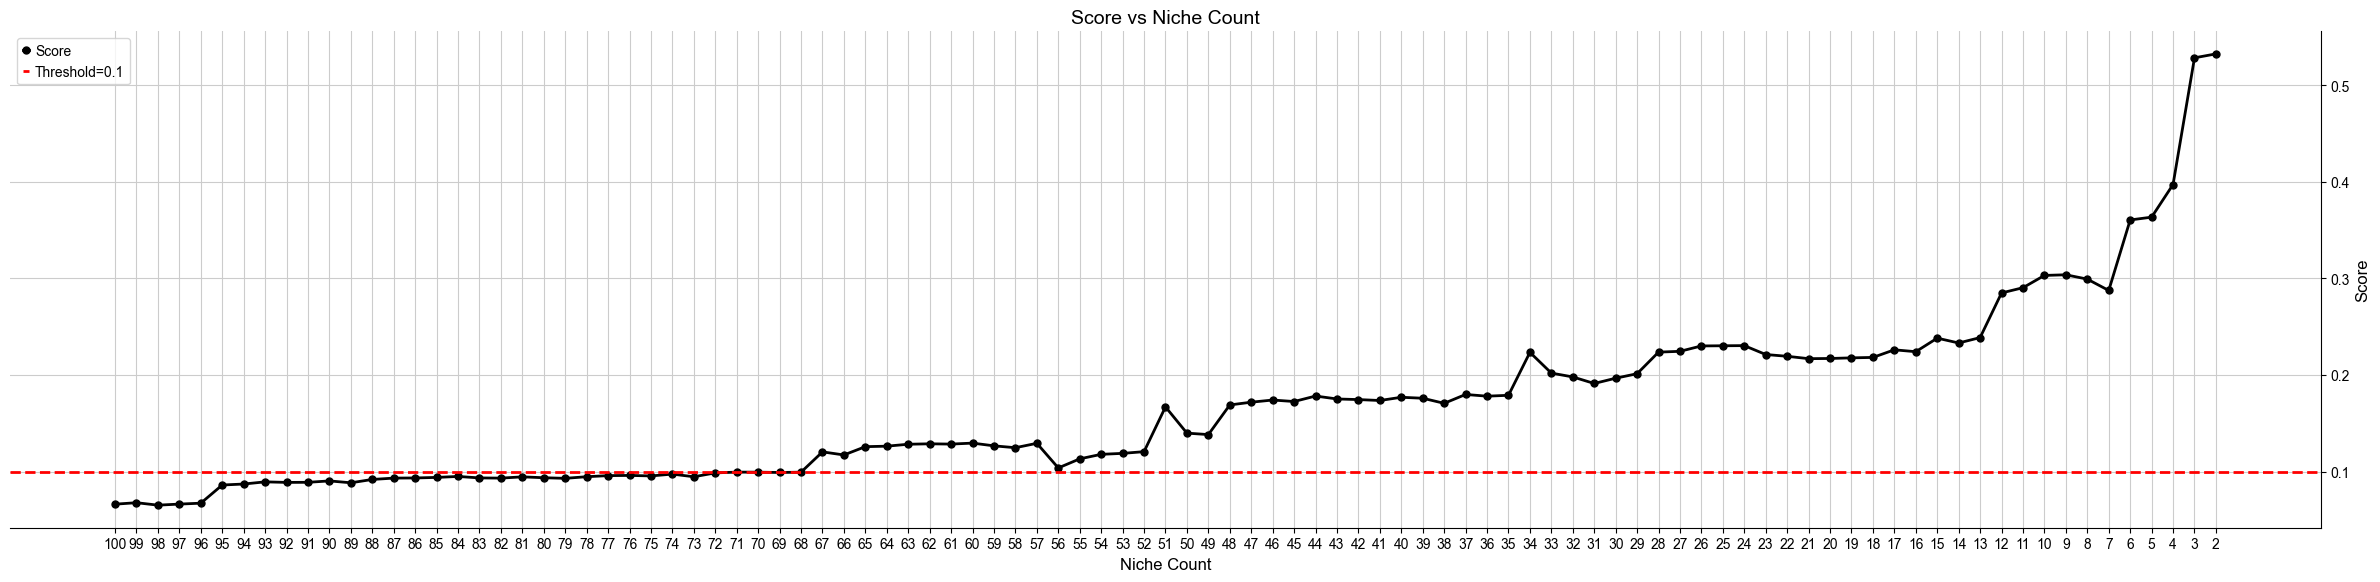

Done!



In [11]:
adata_list, adata_concat = model.select_solution(n_niche=None,  # default
                                                 niche_key=f'niche_label',  # default 
                                                 auto=True,  # default
                                                 metric='jsd',  # default
                                                 threshold=0.1,  # default
                                                 return_adata=True,  # default
                                                 plot=True,  # default
                                                 save=False,  # default
                                                 fig_size=(24, 6),  # default
                                                 save_dir=save_dir, 
                                                 file_name=f'score_vs_nichecount_basic.pdf',
                                                 )

Transfer the niche label to other data based on the similarity between cell type distributions of niche and cell neighborhood.

In [12]:
trans_list, trans_concat = model.label_transfer(assign_metric='jsd', 
                                                niche_key='niche_label', 
                                                return_adata=True,
                                                )

Assigning cells to fixed niches...
Done!



Concatenate the data

In [13]:
adata_concat = ad.concat([adata_concat, trans_concat], label='labeltransfer', keys=['origin', 'transfered'])

In [15]:
# reorder
slice_name_list = np.loadtxt(data_dir + f"slice_name_list.txt", dtype=str, delimiter=" ").tolist()

adata_list = []
for slice_name in slice_name_list:
    adata = adata_concat[adata_concat.obs['slice_name'] == slice_name, :].copy()
    adata_list.append(adata)

adata_concat = ad.concat(adata_list, label='slice_name', keys=slice_name_list)

In [16]:
adata_concat.uns['minjsd_score_basic'] = model.score_list_minjsd_basic.copy()
adata_concat.uns['cn_count_list_basic'] = model.cn_count_list_basic.copy()

Save and reload the results

In [ ]:
adata_concat.write_h5ad(save_dir + f'Harmonics_labeltransfer_result_0.h5ad')

In [4]:
slice_name_list = np.loadtxt(data_dir + f"slice_name_list.txt", dtype=str, delimiter=" ").tolist()
adata_new = ad.read_h5ad(save_dir + f'Harmonics_labeltransfer_result_0.h5ad')
# adata_new = adata_concat.copy()
adata_new

AnnData object with n_obs × n_vars = 2081549 × 1122
    obs: 'donor_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'subclass_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'cell_type', 'tissue', 'development_stage', 'slice_name', 'celltype_idx', 'n_neighbors', 'niche_label', 'labeltransfer'
    uns: 'cn_count_list_basic', 'minjsd_score_basic'
    obsm: 'micro_dist', 'onehot', 'spatial', 'spatial_ccf'

Load the data that contains the niche assignment defined using the whole dataset without label transfer

In [5]:
adata_new.obs['niche_label_trans'] = adata_new.obs['niche_label'].copy()
adata_tmp = ad.read_h5ad(save_dir + f'Harmonics_result_0.h5ad')
adata_new.obs['niche_label'] = adata_tmp.obs['niche_label'].copy()
del adata_tmp

### Compare the results obtained through the two modes

In [6]:
niche_colors = ['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6', '#a30059', '#ffdbe5', '#7a4900', '#0000a6',
                '#63ffac', '#b79762', '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c', '#1b4400', '#4fc601',
                '#3b5dff', '#4a3b53', '#ff2f80', '#61615a', '#001e09', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa',
                '#d16100', '#ddefff', '#000035', '#7b4f4b', '#a1c299', '#300018', '#0aa6d8', '#013349', '#00846f', '#372101',
                '#ffb500', '#c2ffed', '#a079bf', '#cc0744', '#c0b9b2', '#c2ff99', '#ba0900', '#00489c', '#6f0062', '#0cbd66',
                '#eec3ff', '#456d75', '#b77b68', '#7a87a1', '#788d66', '#885578', '#fad09f', '#ff8a9a', '#d157a0', '#bec459', 
                '#456648', '#117743', '#d0a1ff', '#ff6600', '#3399ff', '#990000', '#66ff66']
niche_color_dict = {str(i): niche_colors[i] for i in range(len(niche_colors))}

mbr = sorted(set(adata_new.obs['major_brain_region']))
mbr_colors = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', 
              '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']
mbr_color_dict = {mbr[i]: mbr_colors[i] for i in range(len(mbr))}

C57BL6J-3.001
FMI:  0.8099


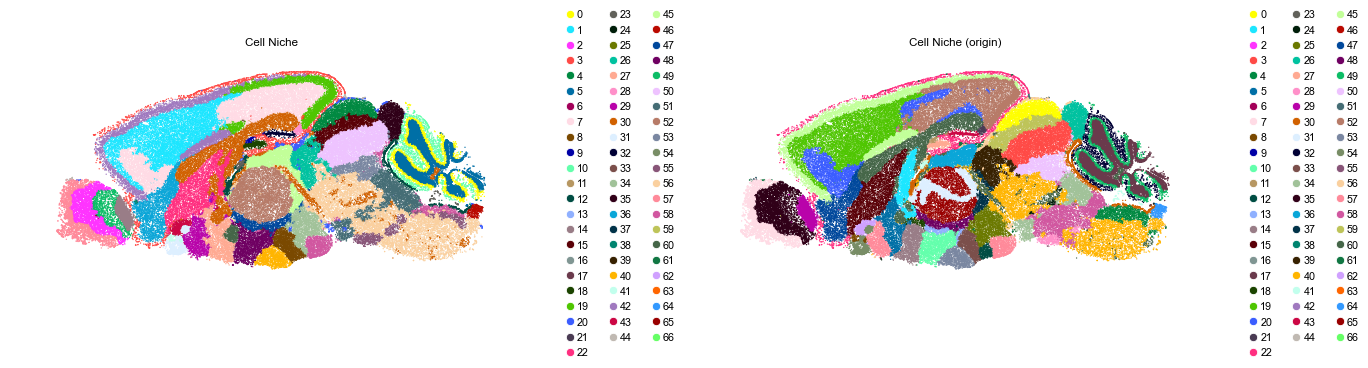

C57BL6J-3.002
FMI:  0.8732


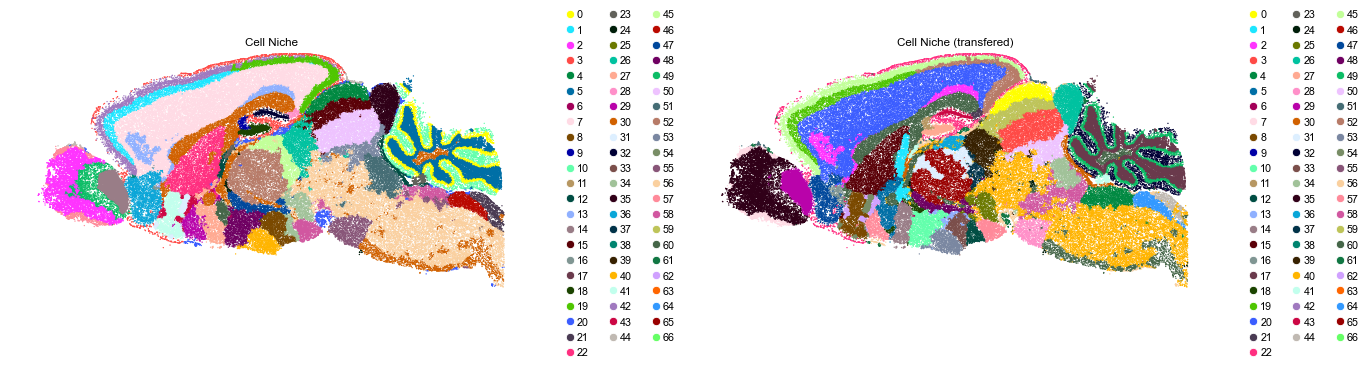

C57BL6J-3.003
FMI:  0.8861


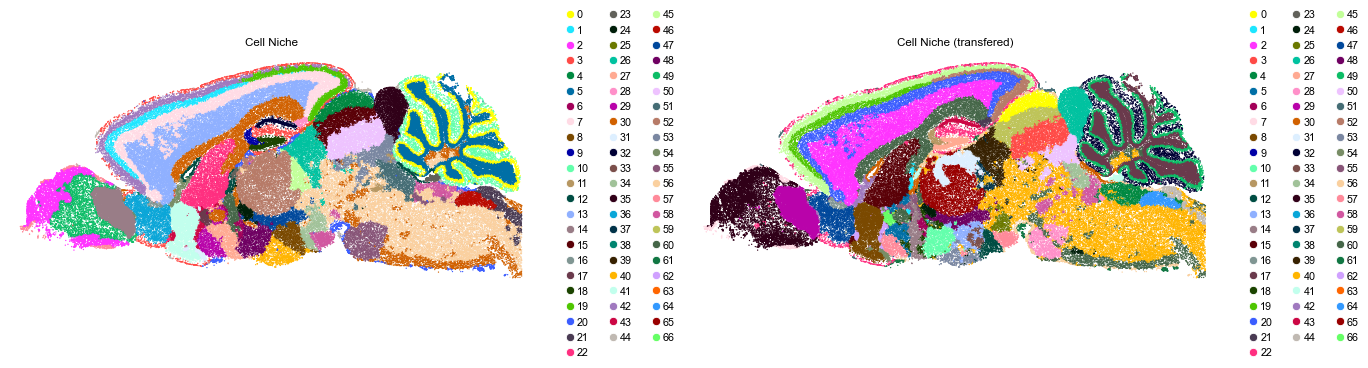

C57BL6J-3.004
FMI:  0.9117


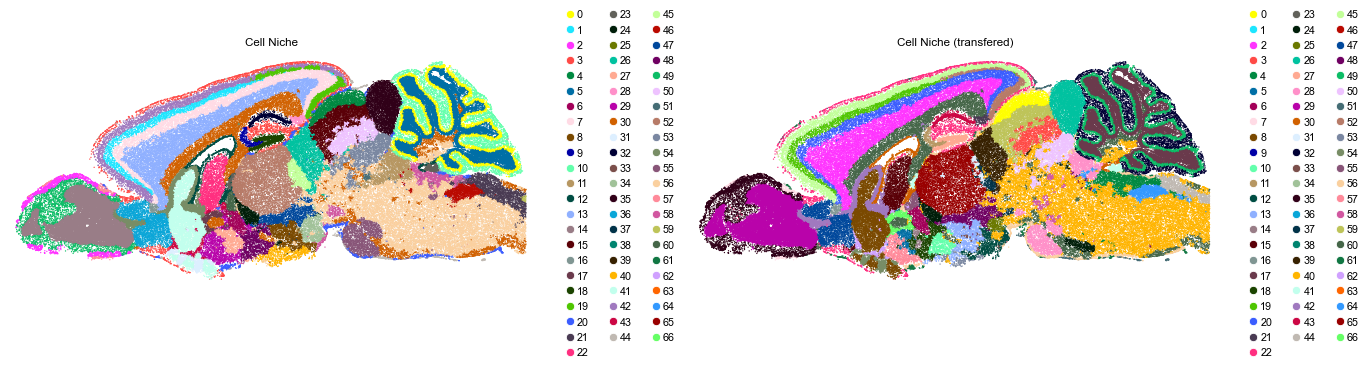

C57BL6J-3.005
FMI:  0.9353


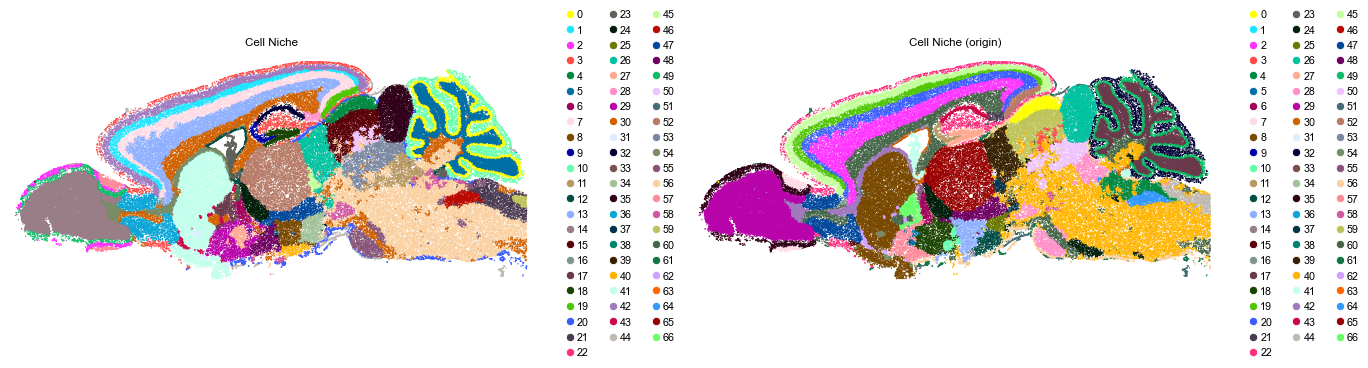

C57BL6J-3.006
FMI:  0.8944


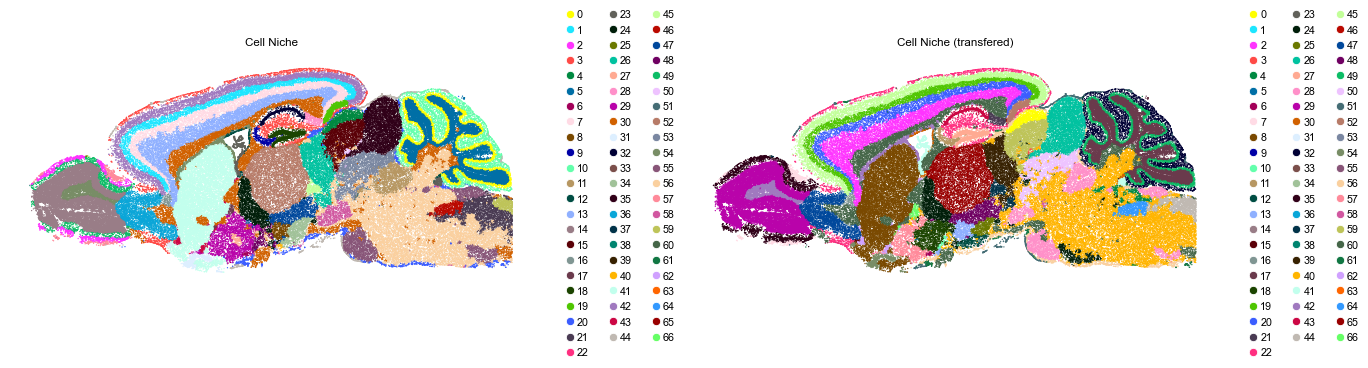

C57BL6J-3.007
FMI:  0.9019


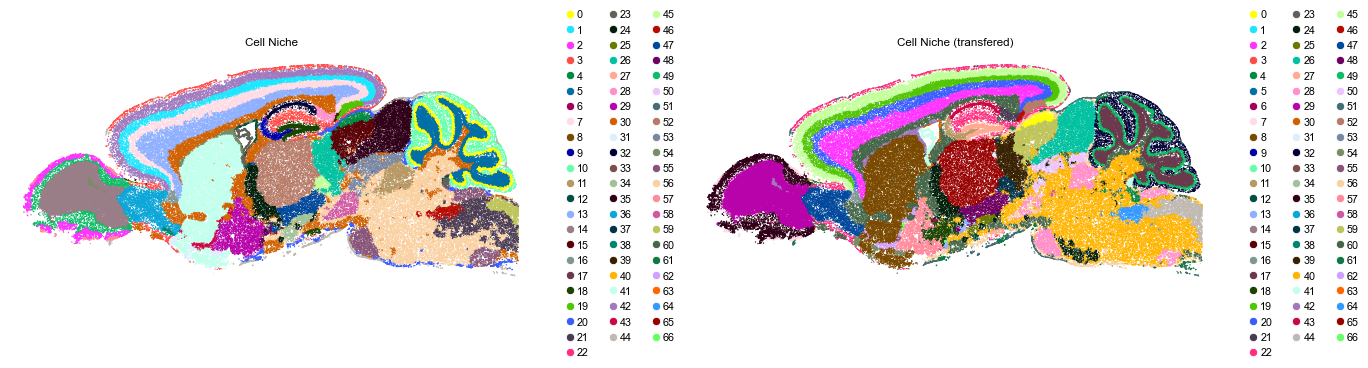

C57BL6J-3.008
FMI:  0.8576


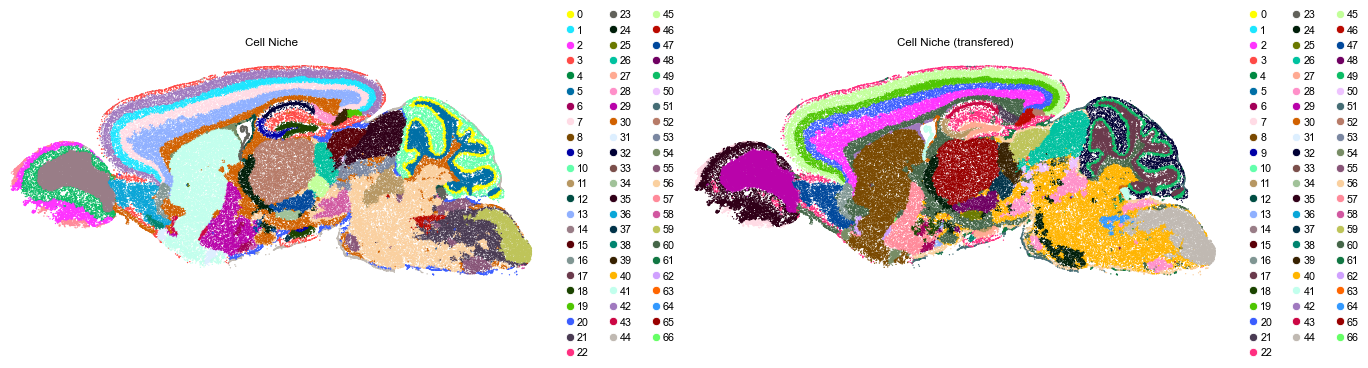

C57BL6J-3.009
FMI:  0.8653


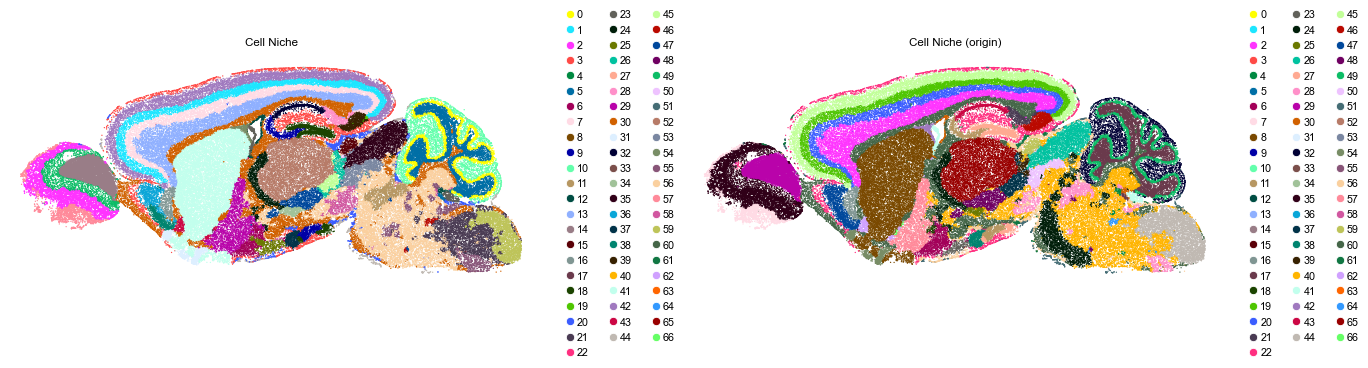

C57BL6J-3.010
FMI:  0.8763


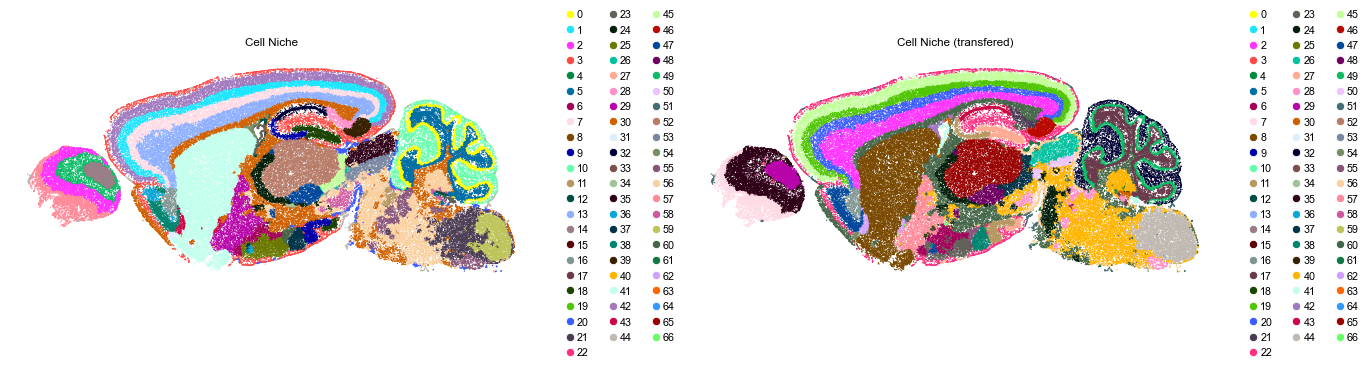

C57BL6J-3.011
FMI:  0.9291


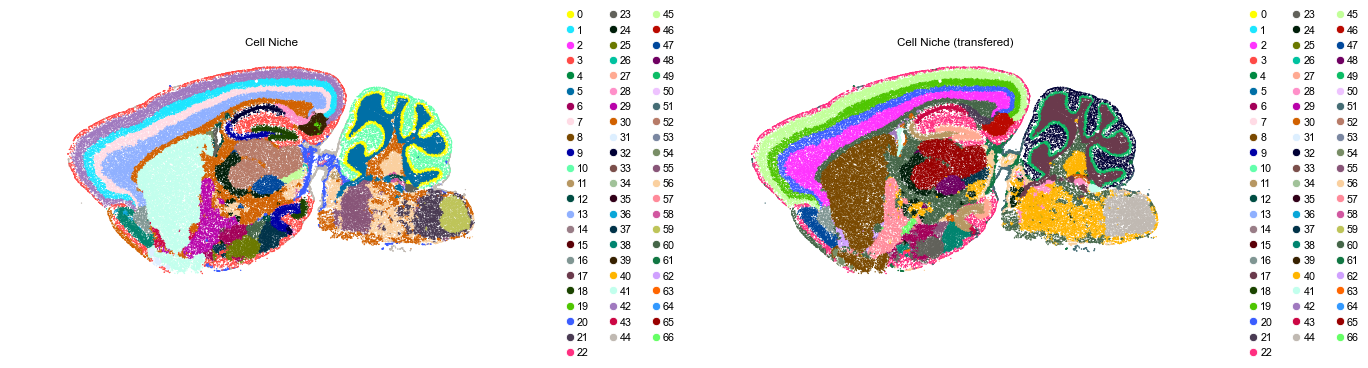

C57BL6J-3.012
FMI:  0.9592


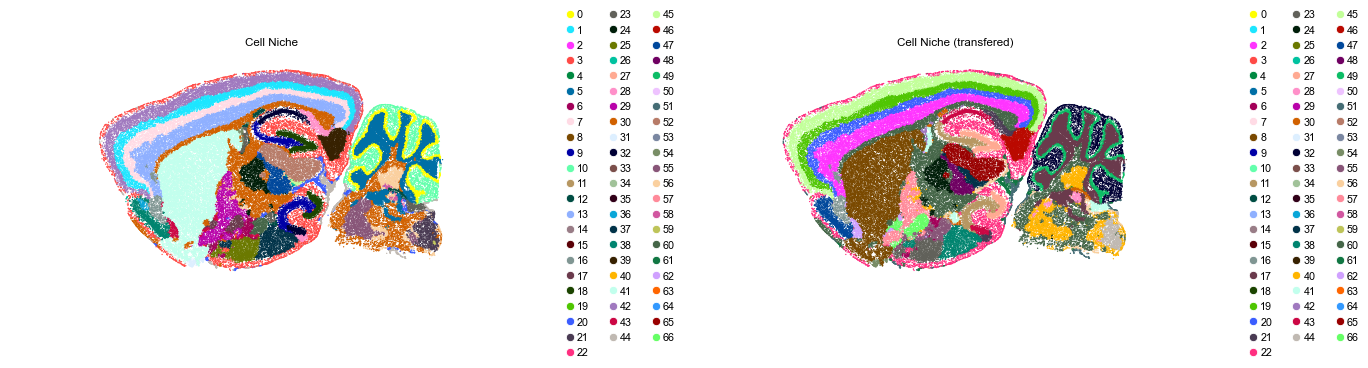

C57BL6J-3.013
FMI:  0.9695


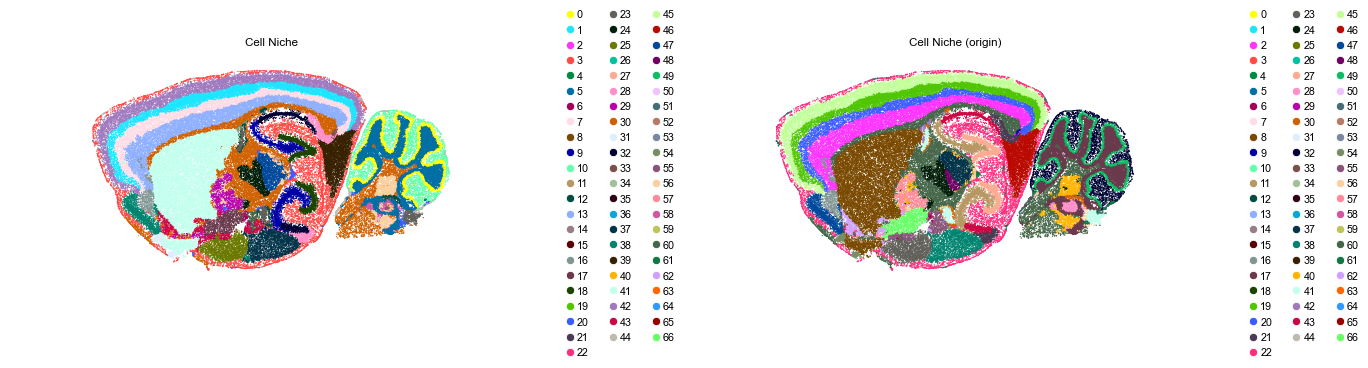

C57BL6J-3.015
FMI:  0.9756


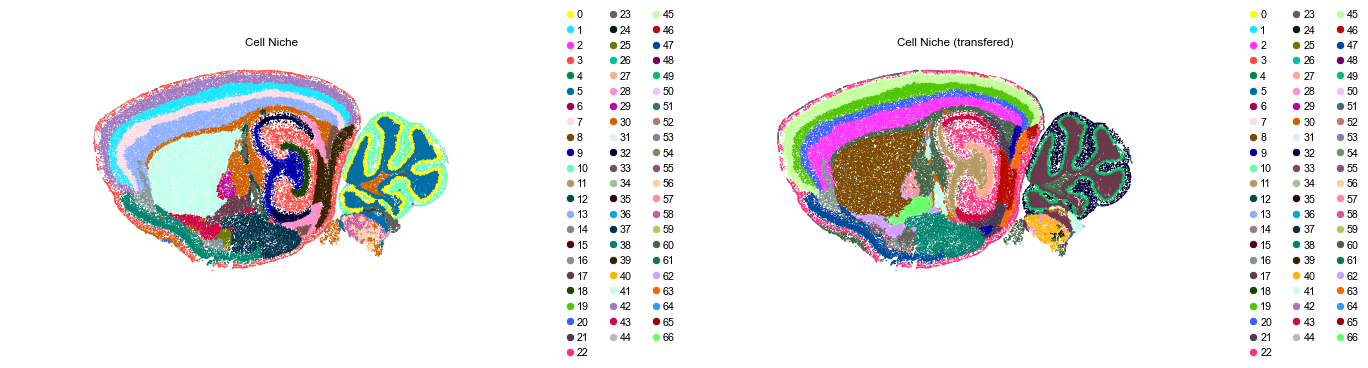

C57BL6J-3.016
FMI:  0.9641


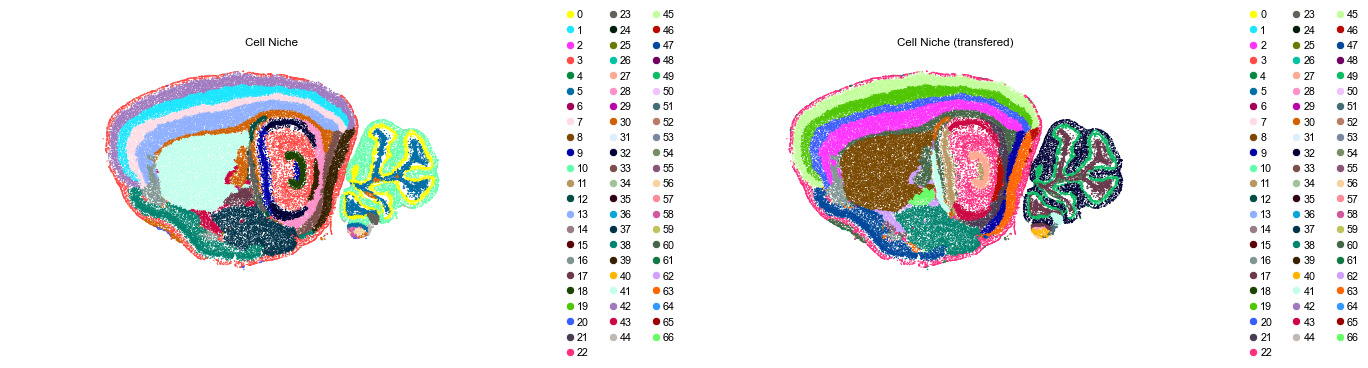

C57BL6J-3.017
FMI:  0.9667


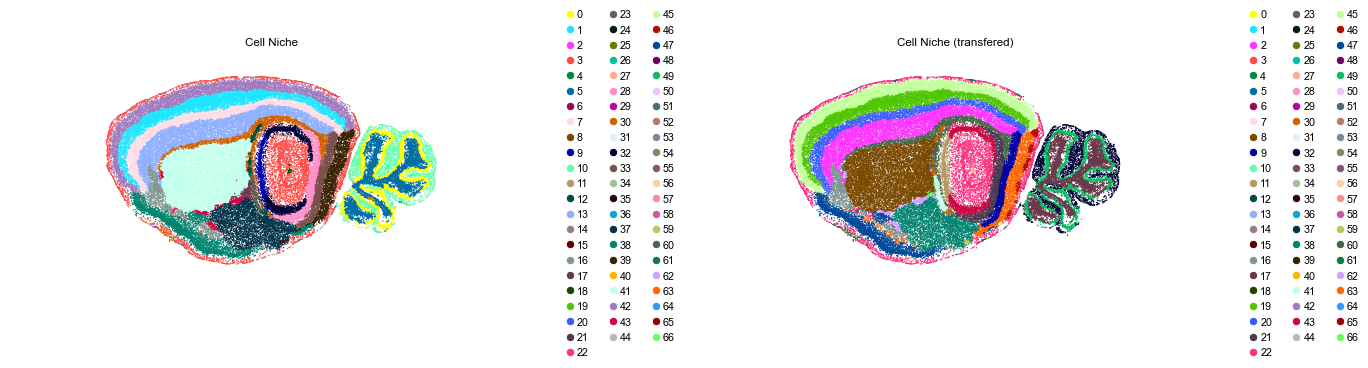

C57BL6J-3.019
FMI:  0.9576


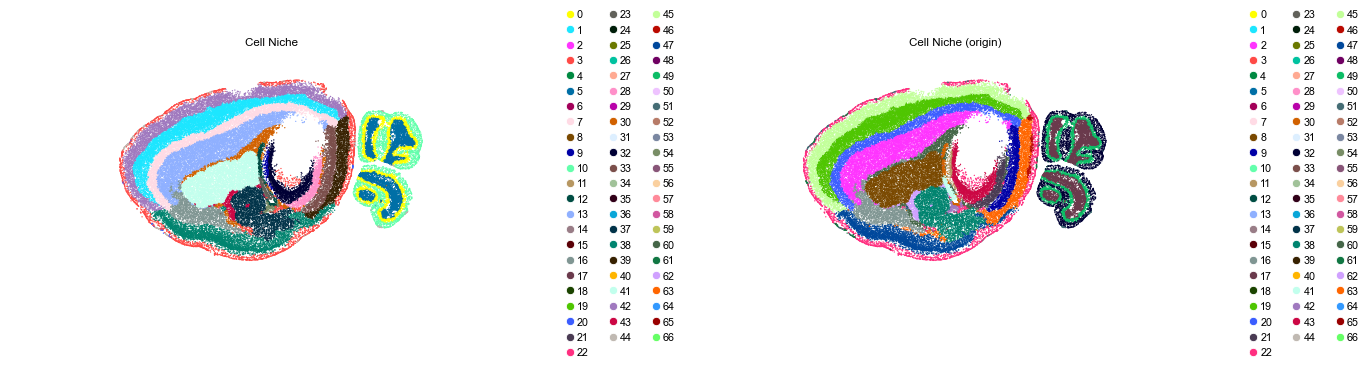

C57BL6J-3.020
FMI:  0.9548


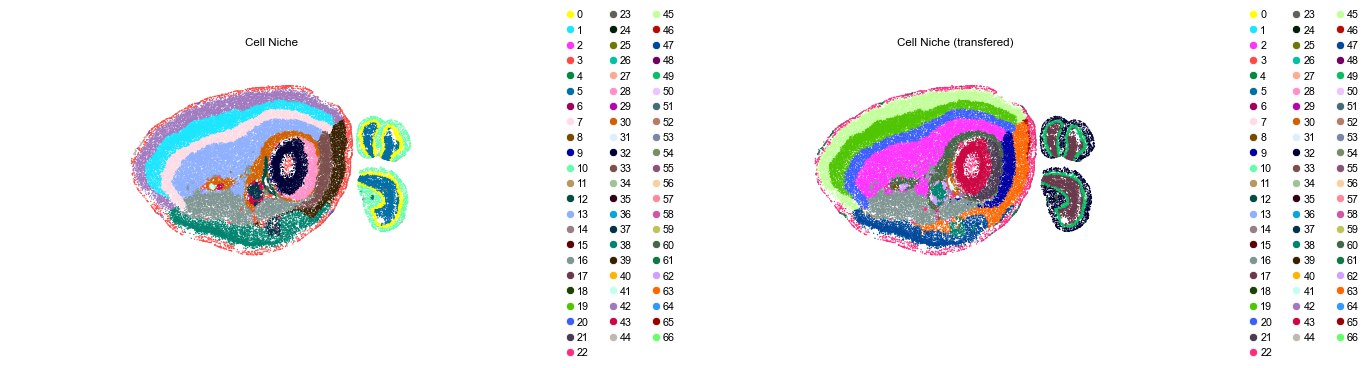

C57BL6J-3.021
FMI:  0.9503


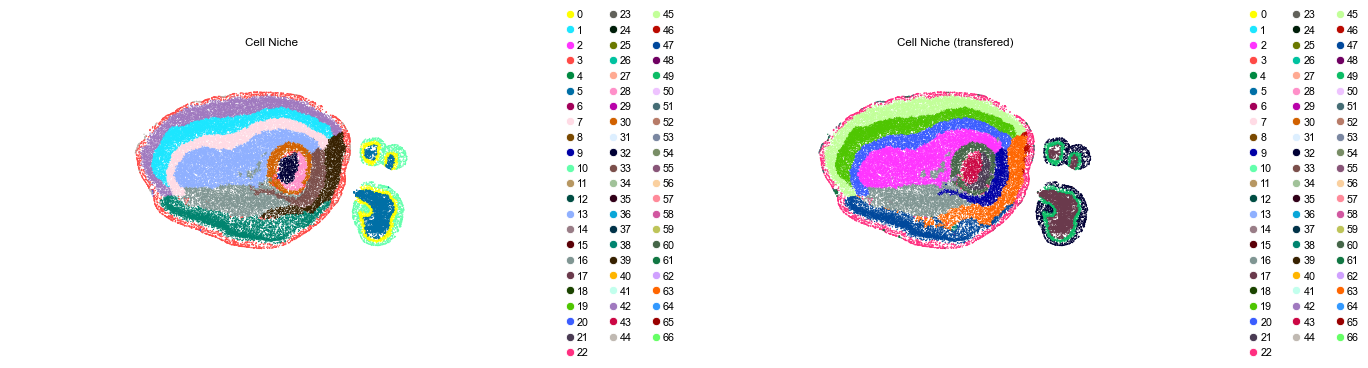

C57BL6J-3.022
FMI:  0.9047


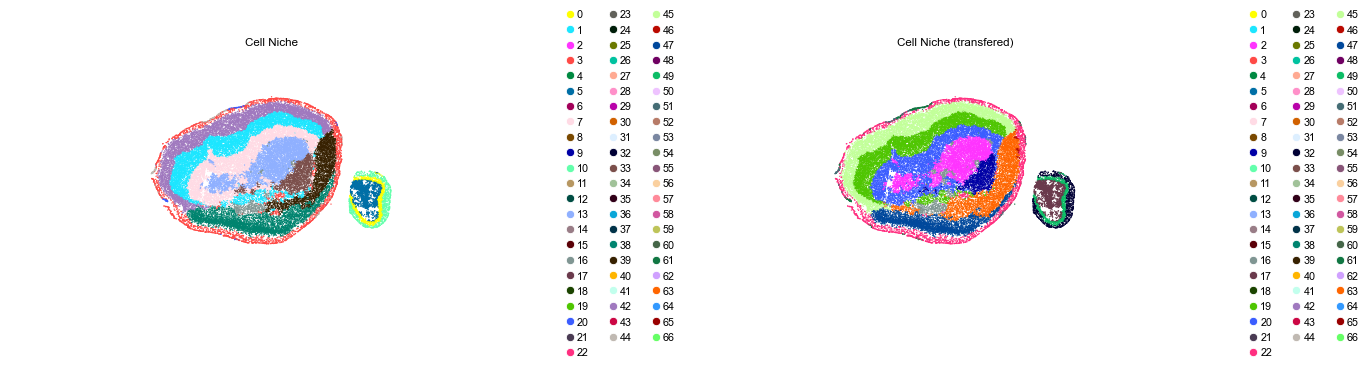

C57BL6J-3.023
FMI:  0.8981


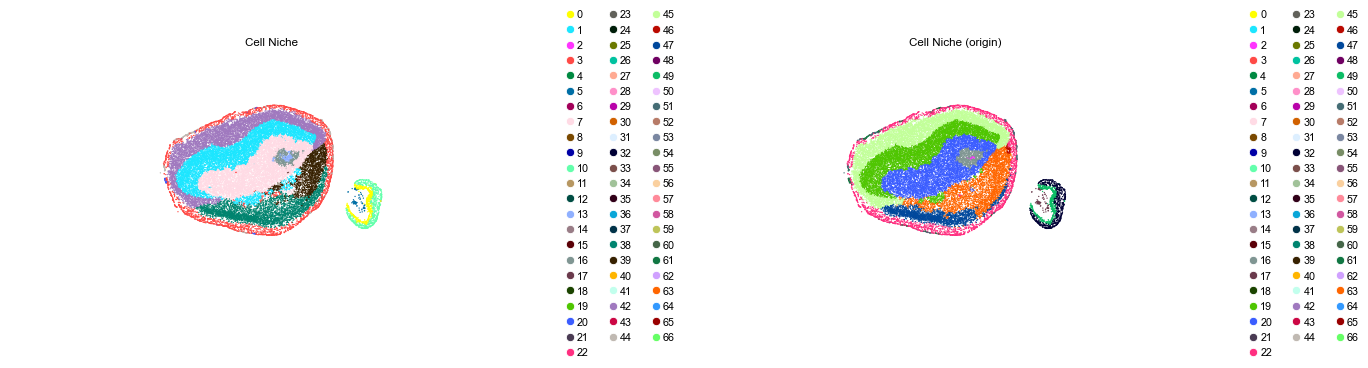

C57BL6J-3.024
FMI:  0.9282


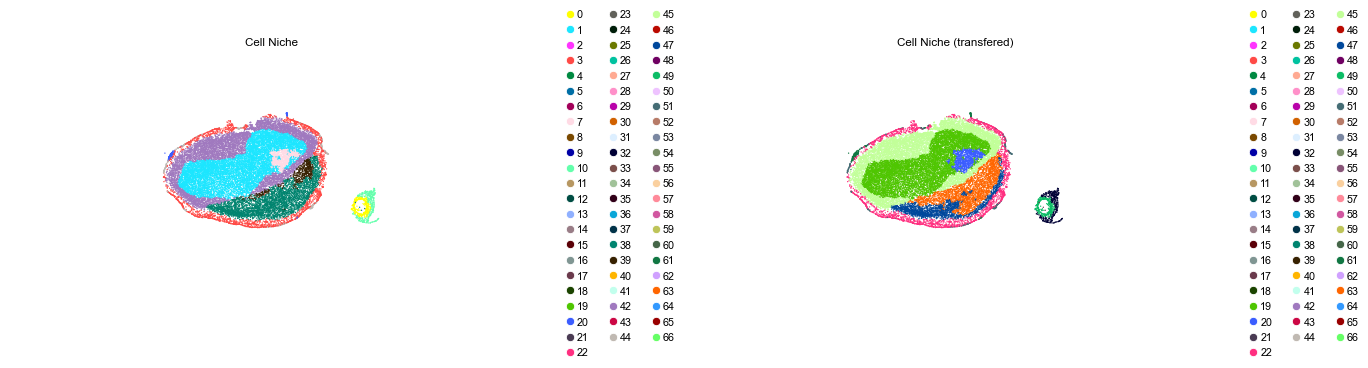

C57BL6J-3.025
FMI:  0.9838


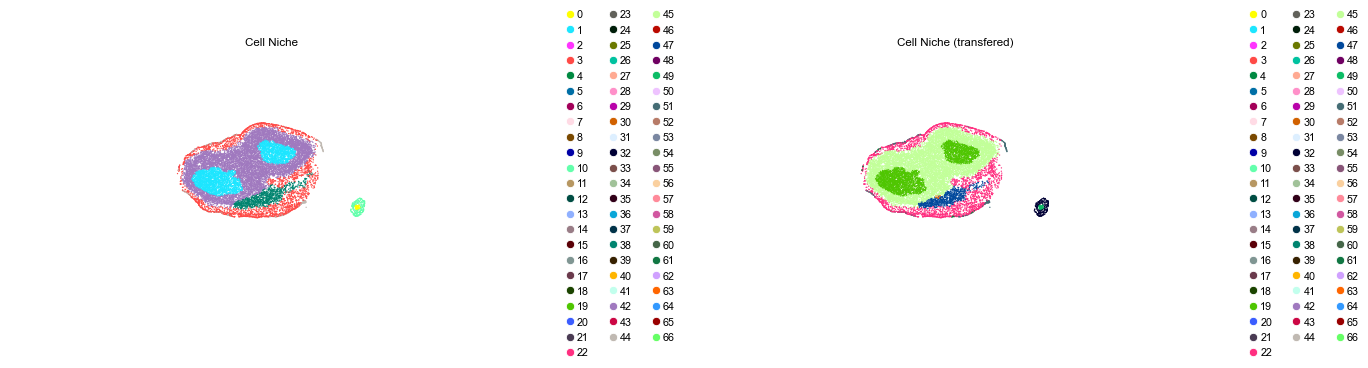

In [8]:
fmi_list = []
for i in range(len(slice_name_list)):
    
    print(slice_name_list[i])
    adata = adata_new[adata_new.obs['slice_name'] == slice_name_list[i], :].copy()
    fmi = fowlkes_mallows_score(adata.obs['niche_label'], adata.obs['niche_label_trans'])
    fmi_list.append(fmi)
    print(f"FMI: {fmi: .4f}")

    fig, axes = plt.subplots(1, 2, figsize=(23, 6))

    sc.pl.embedding(adata, basis='spatial', color='niche_label', palette=niche_color_dict,
                    ax=axes[0], s=10, show=False, frameon=False, title='Cell Niche', legend_fontsize=16)

    sc.pl.embedding(adata, basis='spatial', color='niche_label_trans', palette=niche_color_dict, 
                    ax=axes[1], s=10, show=False, frameon=False, title=f"Cell Niche ({adata.obs['labeltransfer'][0]})", legend_fontsize=16)
    
    x_mean = (max(adata.obsm['spatial'][:, 0]) + min(adata.obsm['spatial'][:, 0])) / 2
    y_mean = (max(adata.obsm['spatial'][:, 1]) + min(adata.obsm['spatial'][:, 1])) / 2
    if x_mean-7800 > min(adata.obsm['spatial'][:, 0]) or x_mean+7800 < max(adata.obsm['spatial'][:, 0]):
        raise ValueError('Please adjust the x_lim !')
    if y_mean-3600 > min(adata.obsm['spatial'][:, 1]) or y_mean+3600 < max(adata.obsm['spatial'][:, 1]):
        raise ValueError('Please adjust the y_lim !')
    for ax in axes:
        ax.set_xlim(x_mean-7800, x_mean+7800)
        ax.set_ylim(y_mean-3600, y_mean+3600)

    niche_legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=label,
            markerfacecolor=color, markersize=10)
        for label, color in niche_color_dict.items()
    ]
    axes[0].legend(handles=niche_legend_elements, loc=(1.05, -0.3), frameon=False, ncol=3)
    axes[0].axis('off')

    niche_legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=label,
            markerfacecolor=color, markersize=10)
        for label, color in niche_color_dict.items()
    ]
    axes[1].legend(handles=niche_legend_elements, loc=(1.05, -0.3), frameon=False, ncol=3)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

Show the FMI score for each slice by comparing the niche assignments obtained from the two modes.

Mean FMI: 0.92  Median FMI: 0.93


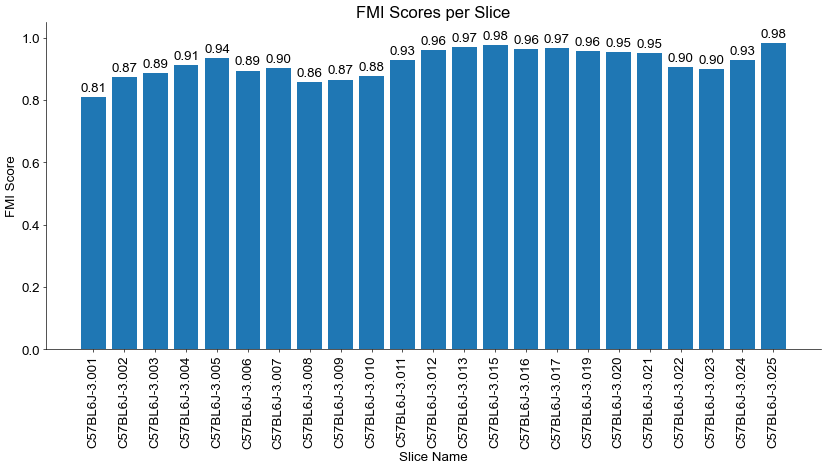

In [9]:
mean_val = np.mean(fmi_list)
median_val = np.median(fmi_list)
print(f'Mean FMI:{mean_val: .2f}  Median FMI:{median_val: .2f}')

plt.figure(figsize=(14, 8))

bars = plt.bar(slice_name_list, fmi_list)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=16)

plt.ylabel('FMI Score', fontsize=16)
plt.xlabel('Slice Name', fontsize=16)
plt.title('FMI Scores per Slice', fontsize=20)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(False)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()